In [2]:
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
import scipy 
import argparse

from commons import *

# Function to compute R², ICC, and CoV
def compute_stats(X, Y):
    r = np.corrcoef(X, Y)[0, 1]
    r_sq = r**2 if not np.isnan(r) else np.nan

    n = len(X)
    k = 2
    if n < 2:
        icc_val = np.nan
    else:
        subject_means = (X + Y) / 2
        grand_mean = np.mean(subject_means)
        BMS = (k / (n - 1)) * np.sum((subject_means - grand_mean)**2)
        EMS = np.sum((X - subject_means)**2 + (Y - subject_means)**2) / (n * (k - 1))
        icc_val = (BMS - EMS) / (BMS + (k - 1) * EMS) if (BMS + (k - 1) * EMS) != 0 else np.nan

    avg_val = (X + Y) / 2.0
    diff_val = Y - X
    cov_val = (np.std(diff_val) / np.mean(avg_val)) * 100 if np.mean(avg_val) != 0 else np.nan

    return (r_sq, icc_val, cov_val)

# # Function to gather data pairs for comparison
# def gather_pairs(subjectData, type1, type2):
#     X_list, Y_list = [], []
#     for subjID in subjectData.keys():
#         vals_t1 = subjectData[subjID].get(type1, np.nan)
#         vals_t2 = subjectData[subjID].get(type2, np.nan)
#         if isinstance(vals_t1, np.ndarray) and isinstance(vals_t2, np.ndarray):
#             if not np.isnan(vals_t1[0]) and not np.isnan(vals_t2[0]):
#                 X_list.append(vals_t1)
#                 Y_list.append(vals_t2)
#     return (np.vstack(X_list), np.vstack(Y_list)) if X_list else (np.array([]), np.array([]))


def gather_pairs(subjectData, type1, type2):
    X_list, Y_list = [], []
    for subjID in subjectData.keys():
        vals_t1 = subjectData[subjID].get(type1, np.nan)
        vals_t2 = subjectData[subjID].get(type2, np.nan)
        if isinstance(vals_t1, np.ndarray) and isinstance(vals_t2, np.ndarray):
            if not np.any(np.isnan(vals_t1[0])) and not np.any(np.isnan(vals_t2[0])):
                X_list.append(vals_t1)
                Y_list.append(vals_t2)
    return (np.vstack(X_list), np.vstack(Y_list)) if X_list else (np.array([]), np.array([]))


# Load and organize data
def load_data(data_folder, mode='output'):
    subjectData = {}
    pattern = re.compile(r'(HC\d+)_(LD1|LD2|SD)\.mat', re.IGNORECASE)
    mat_files = list(Path(data_folder).glob("*.mat"))

    for fpath in mat_files:
        match = pattern.search(fpath.name)
        if not match:
            continue
        subjID, dataType = match.group(1), match.group(2)

        mat_data = loadmat(fpath)
        if mode=='output':  # vp, ktrans, ve, kep
            if 'predictions' not in mat_data:
                continue
            predictions = mat_data['predictions']
            predictions[:, [1, 2, 3]] = predictions[:, [2, 1, 3]]
        elif mode=='input':  # vp, ktrans, kep, ve
            if 'kv_nontumor' not in mat_data:
                continue
            predictions = mat_data['kv_nontumor']
            predictions[:, [1, 2, 3]] = predictions[:, [3, 1, 2]]
        elif mode=='input_old':  # vp, ktrans, ve, 0 
            if 'kv_nontumor' not in mat_data:
                continue
            predictions = mat_data['kv_nontumor']
            predictions[:, [1, 2]] = predictions[:, [2, 1]]
            predictions[:, 3] = predictions[:, 2] / predictions[:, 1]
        else:
            continue
        # new order: vp ve ktrans kep 
        predictions[:,2]*=60.0
        predictions[:,3]*=60.0 # to 1/min 
        
        param_mean = np.mean(predictions, axis=0)
        if subjID not in subjectData:
            subjectData[subjID] = {}
        subjectData[subjID][dataType] = param_mean

        # New code block: process c_nontumor if available
        if 'c_nontumor' in mat_data:
            c_nontumor = mat_data['c_nontumor']
            c_mean = np.mean(c_nontumor, axis=0)
            c_auc = np.trapz(c_mean)  # compute area under the curve (AUC)
            # Store as a one-element array for compatibility with gather_pairs
            subjectData[subjID][dataType + '_auc'] = np.array([c_auc])
        if 'fits_T1_artery' in mat_data:
            r1_artery = mat_data['fits_T1_artery'][:,1:-2]
            r1_artery = np.mean(r1_artery, axis=0)
            subjectData[subjID][dataType + '_r1artery'] = np.array([r1_artery])
        if 'fits_T1_nontumor' in mat_data:   
            r1_nontumor = mat_data['fits_T1_nontumor'][:,1:-2]
            r1_nontumor = np.mean(r1_nontumor, axis=0)
            subjectData[subjID][dataType + '_r1nontumor'] = np.array([r1_nontumor])
    return subjectData

# Define parameter names with superscripts/subscripts
param_names = [r'$v_p$', r'$v_e$', r'$K^{trans}$(1/min)', r'$k_{ep}$(1/min)']

# Function to create scatter plots with equal axis scaling and annotation in lower right
def scatter_plot(ax, X, Y, title_str, stats_tuple, xlab='X', ylab='Y'):
    sns.scatterplot(x=X, y=Y, ax=ax, marker='o', edgecolor='none')
    r_sq, icc_val, cov_val = stats_tuple
    ax.set_title(title_str, fontsize=12)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    # Ensure equal axis scaling
    min_val = min(X.min(), Y.min())
    max_val = max(X.max(), Y.max())
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', linewidth=1)

    # Text annotation in the lower right
    ax.text(max_val - 0.3*(max_val - min_val), min_val + 0.05*(max_val - min_val),
            f"R² = {r_sq:.3f}\nICC = {icc_val:.3f}\nCoV = {cov_val:.2f}%",
            fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

# Function to create Bland-Altman plots with R², ICC, and CoV annotation
def bland_altman_plot(ax, X, Y, title_str, stats_tuple):
    """
    Create a Bland–Altman plot with equal axis scaling.
    """
    avg_val = (X + Y) / 2.0
    diff_val = Y - X

    sns.scatterplot(x=avg_val, y=diff_val, ax=ax, marker='o', edgecolor='none')
    ax.set_title(f'{title_str}', fontsize=12)

    mean_diff = np.mean(diff_val)
    std_diff = np.std(diff_val)
    loa_lower = mean_diff - 1.96 * std_diff
    loa_upper = mean_diff + 1.96 * std_diff

    ax.axhline(mean_diff, color='red', linestyle='--', linewidth=1.5)
    ax.axhline(loa_lower, color='black', linestyle='--')
    ax.axhline(loa_upper, color='black', linestyle='--')
    ax.set_xlabel('Average')
    ax.set_ylabel('Difference (Y - X)')
    
    # Ensure equal axis scaling
    x_min, x_max = avg_val.min(), avg_val.max()
    y_min, y_max = diff_val.min(), diff_val.max()
    axis_limit = 0.9*max(abs(x_min), abs(x_max), abs(y_min), abs(y_max), abs(loa_upper), abs(loa_lower))
    ax.set_xlim([0, 2*axis_limit])
    ax.set_ylim([-axis_limit, axis_limit])
    ax.grid(False)
    r_sq, icc_val, cov_val = stats_tuple
    ax.text(axis_limit * 0.4, -axis_limit * 0.9,
            f"R² = {r_sq:.3f}\nICC = {icc_val:.3f}\nCoV = {cov_val:.2f}%",
            fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

# Main function to run the analysis
def main(data_folder, output_folder, mode='output'):
    subjectData = load_data(data_folder, mode)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Compute repeatability statistics for the parameters (predictions)
    LD1_LD2, LD2_LD2 = gather_pairs(subjectData, 'LD1', 'LD2')
    LD1_SD, SD_SD = gather_pairs(subjectData, 'LD1', 'SD')
    LD2_SD, SD2_SD = gather_pairs(subjectData, 'LD2', 'SD')
    print(LD1_LD2.shape)
    print(LD2_LD2.shape)
    stats = {
        "LD1 vs LD2": np.array([compute_stats(LD1_LD2[:, p], LD2_LD2[:, p]) for p in range(3)]),
        "LD1 vs SD": np.array([compute_stats(LD1_SD[:, p], SD_SD[:, p]) for p in range(3)]),
        "LD2 vs SD": np.array([compute_stats(LD2_SD[:, p], SD2_SD[:, p]) for p in range(3)])
    }

    sns.set(style="whitegrid")

    # Replot Bland-Altman Plots with equal axis scaling for prediction parameters
    for comparison, stat_values in stats.items():
        fig, axes = plt.subplots(1, 4, figsize=(17, 4.5))
        fig.suptitle(f"{comparison}", fontsize=14)
    
        if comparison == "LD1 vs LD2":
            X_data, Y_data = LD1_LD2, LD2_LD2
        elif comparison == "LD1 vs SD":
            X_data, Y_data = LD1_SD, SD_SD
        elif comparison == "LD2 vs SD":
            X_data, Y_data = LD2_SD, SD2_SD
        else:
            continue
        
        for p, ax in enumerate(axes):
            # Call your external plotting function MyPlot for additional processing (if needed)
            (R2, ICC, CoV) = MyPlot(X_data[:, p], Y_data[:, p],
                                     [param_names[p], param_names[p]],
                                     np.max(X_data[:, p]),
                                     output_folder,
                                     comparison + '_' + param_names[p],
                                     mode='value_only')
    
            bland_altman_plot(ax, X_data[:, p], Y_data[:, p], param_names[p], (R2, ICC, CoV))
            
        plt.tight_layout()
        plt.show()

    # --- New Section: Analyze c_nontumor AUC repeatability ---
    # Check if any subject has c_nontumor AUC data (stored as 'LD1_auc', etc.)
    if any('LD1_auc' in subjectData[subj] for subj in subjectData):
        c_LD1_LD2, c_LD2_LD2 = gather_pairs(subjectData, 'LD1_auc', 'LD2_auc')
        c_LD1_SD, c_SD_SD   = gather_pairs(subjectData, 'LD1_auc', 'SD_auc')
        c_LD2_SD, c_SD2_SD   = gather_pairs(subjectData, 'LD2_auc', 'SD_auc')

        stats_auc = {
            "AUC LD1 vs LD2": compute_stats(c_LD1_LD2[:, 0], c_LD2_LD2[:, 0]),
            "AUC LD1 vs SD": compute_stats(c_LD1_SD[:, 0], c_SD_SD[:, 0]),
            "AUC LD2 vs SD": compute_stats(c_LD2_SD[:, 0], c_SD2_SD[:, 0])
        }

        # Plot Bland–Altman plots for c_nontumor AUC comparisons
        for comparison, stat_val in stats_auc.items():
            if comparison == "AUC LD1 vs LD2":
                X_data, Y_data = c_LD1_LD2[:, 0], c_LD2_LD2[:, 0]
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
                fig, ax = plt.subplots(figsize=(6, 6))
                bland_altman_plot(ax, X_data, Y_data, comparison, stat_val)
                plt.tight_layout()
                plt.show()
            elif comparison == "AUC LD1 vs SD":
                X_data, Y_data = c_LD1_SD[:, 0], c_SD_SD[:, 0]
                MyPlot(X_data, Y_data,['LD1','SD'],np.max(np.array([X_data,Y_data])),output_folder,'ld1vssd_auc',mode='value_only')
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
            elif comparison == "AUC LD2 vs SD":
                X_data, Y_data = c_LD2_SD[:, 0], c_SD2_SD[:, 0]
                MyPlot(X_data, Y_data,['LD2','SD'],np.max(np.array([X_data,Y_data])),output_folder,'ld2vssd_auc',mode='value_only')
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
            else:
                continue

    if any('LD1_r1artery' in subjectData[subj] for subj in subjectData):
        c_LD1_LD2, c_LD2_LD2 = gather_pairs(subjectData, 'LD1_r1artery', 'LD2_r1artery')
        c_LD1_SD, c_SD_SD   = gather_pairs(subjectData, 'LD1_r1artery', 'SD_r1artery')
        c_LD2_SD, c_SD2_SD   = gather_pairs(subjectData, 'LD2_r1artery', 'SD_r1artery')

        stats_auc = {
            "R1 artery LD1 vs LD2": compute_stats(c_LD1_LD2[:, 0], c_LD2_LD2[:, 0]),
            "R1 artery vs SD": compute_stats(c_LD1_SD[:, 0], c_SD_SD[:, 0]),
            "R1 artery vs SD": compute_stats(c_LD2_SD[:, 0], c_SD2_SD[:, 0])
        }

        # Plot Bland–Altman plots for c_nontumor AUC comparisons
        for comparison, stat_val in stats_auc.items():
            if comparison == "R1 artery LD1 vs LD2":
                X_data, Y_data = c_LD1_LD2[:, 0], c_LD2_LD2[:, 0]
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
                fig, ax = plt.subplots(figsize=(6, 6))
                bland_altman_plot(ax, X_data, Y_data, comparison, stat_val)
                plt.tight_layout()
                plt.show()
                MyPlot(X_data, Y_data,['LD1','LD2'],np.max(np.array([X_data,Y_data])),output_folder,'ld1vsld2_r1_artery_pre',mode='do')
            elif comparison == "R1 artery LD1 vs SD":
                X_data, Y_data = c_LD1_SD[:, 0], c_SD_SD[:, 0]
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
            elif comparison == "R1 artery LD2 vs SD":
                X_data, Y_data = c_LD2_SD[:, 0], c_SD2_SD[:, 0]
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
            else:
                continue

    if any('LD1_r1nontumor' in subjectData[subj] for subj in subjectData):
        c_LD1_LD2, c_LD2_LD2 = gather_pairs(subjectData, 'LD1_r1nontumor', 'LD2_r1nontumor')
        c_LD1_SD, c_SD_SD   = gather_pairs(subjectData, 'LD1_r1nontumor', 'SD_r1nontumor')
        c_LD2_SD, c_SD2_SD   = gather_pairs(subjectData, 'LD2_r1nontumor', 'SD_r1nontumor')

        stats_auc = {
            "R1 nontumor LD1 vs LD2": compute_stats(c_LD1_LD2[:, 0], c_LD2_LD2[:, 0]),
            "R1 nontumor vs SD": compute_stats(c_LD1_SD[:, 0], c_SD_SD[:, 0]),
            "R1 nontumor vs SD": compute_stats(c_LD2_SD[:, 0], c_SD2_SD[:, 0])
        }

        # Plot Bland–Altman plots for c_nontumor AUC comparisons
        for comparison, stat_val in stats_auc.items():
            if comparison == "R1 nontumor LD1 vs LD2":
                X_data, Y_data = c_LD1_LD2[:, 0], c_LD2_LD2[:, 0]
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
                fig, ax = plt.subplots(figsize=(6, 6))
                bland_altman_plot(ax, X_data, Y_data, comparison, stat_val)
                plt.tight_layout()
                plt.show()
                MyPlot(X_data, Y_data,['LD1','LD2'],np.max(np.array([X_data,Y_data])),output_folder,'ld1vsld2_r1_nontumor_pre',mode='do')
            elif comparison == "R1 nontumor LD1 vs SD":
                X_data, Y_data = c_LD1_SD[:, 0], c_SD_SD[:, 0]
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
            elif comparison == "R1 nontumor LD2 vs SD":
                X_data, Y_data = c_LD2_SD[:, 0], c_SD2_SD[:, 0]
                _,p = scipy.stats.ttest_rel(X_data, Y_data) 
                print(comparison,' ',p)
            else:
                continue



(10, 4)
(10, 4)
(10, 2)
(10, 2)
(10, 2)
(10, 2)


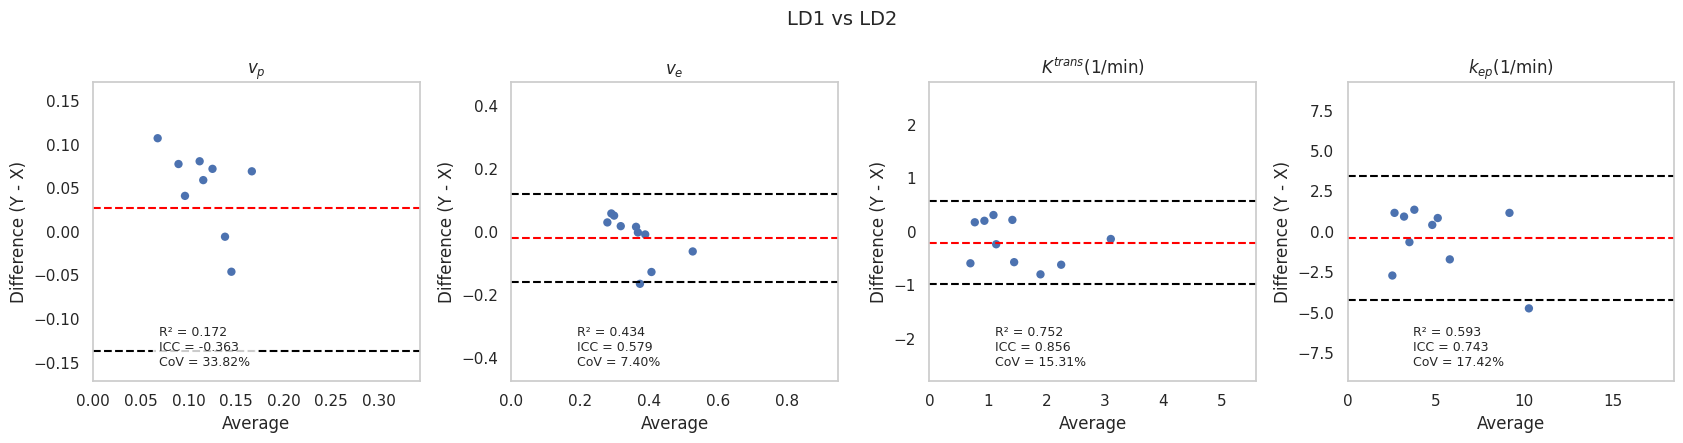

(9, 2)
(9, 2)
(9, 2)
(9, 2)


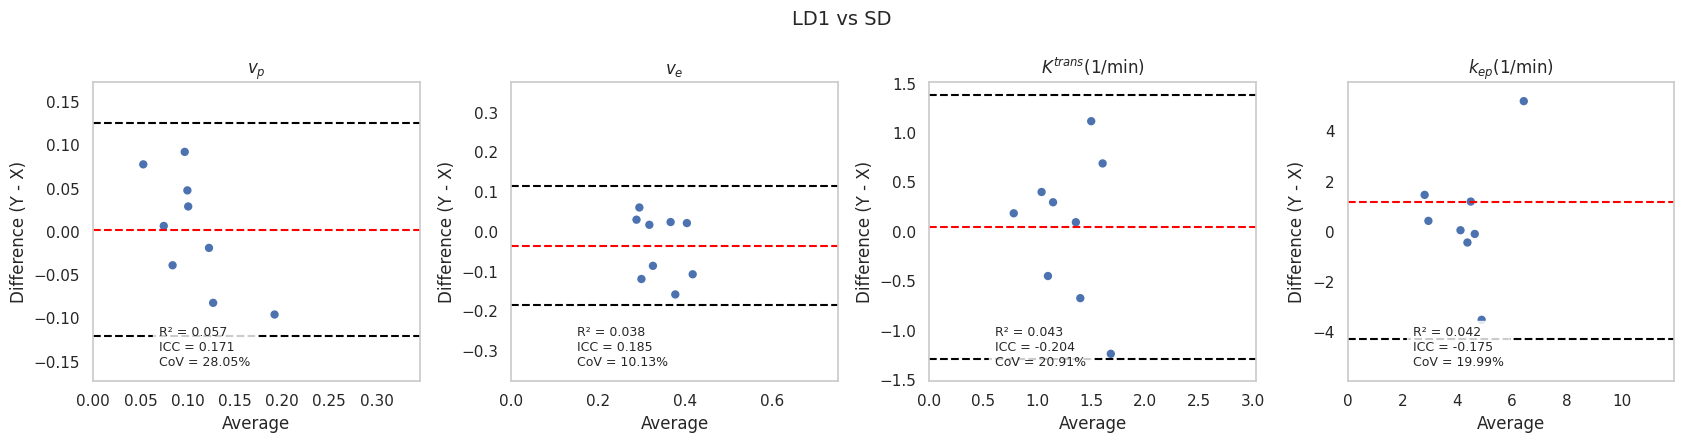

(8, 2)
(8, 2)
(8, 2)
(8, 2)


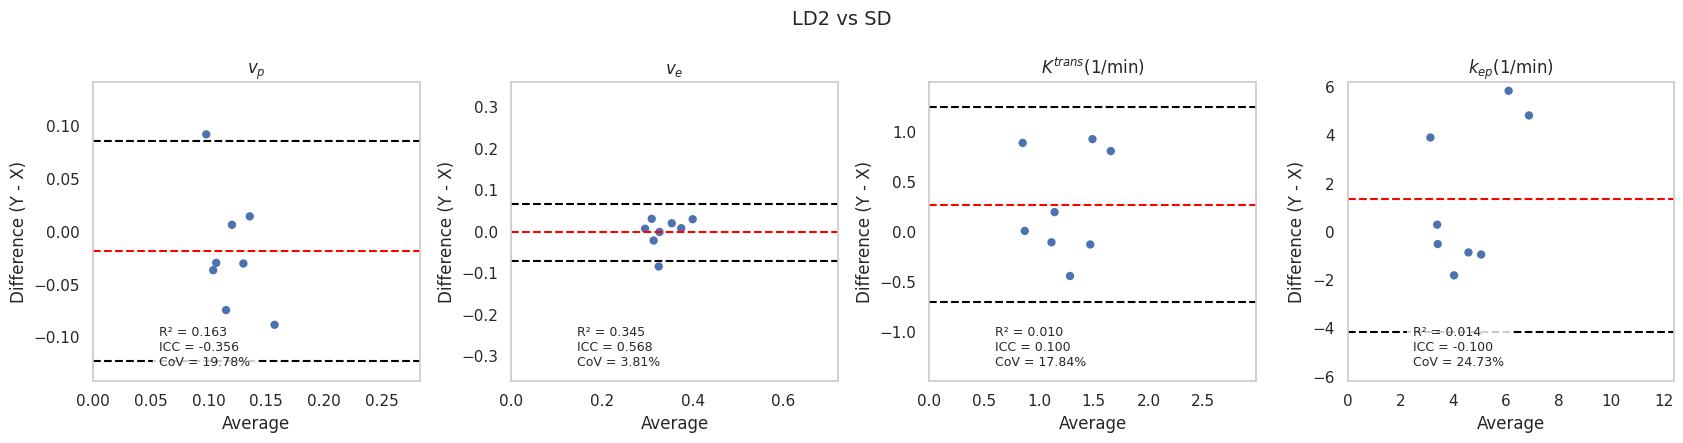

In [3]:
main('./output_mat/Output_extTofts_fitkep_wholePan', './')


(10, 4)
(10, 4)
(10, 2)
(10, 2)
(10, 2)
(10, 2)


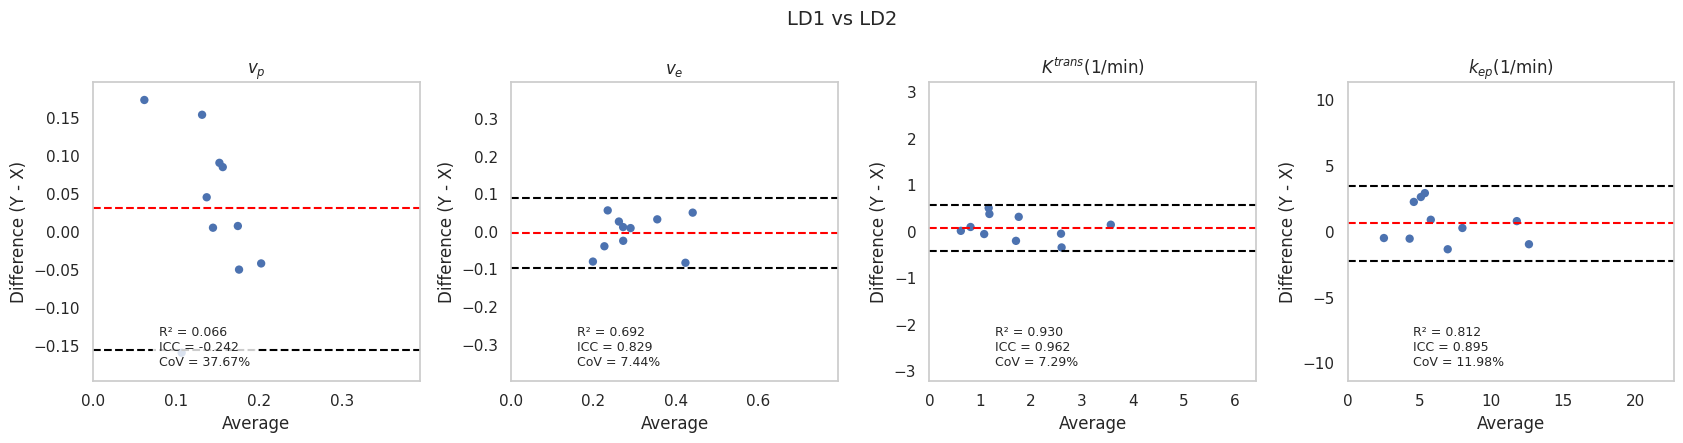

(9, 2)
(9, 2)
(9, 2)
(9, 2)


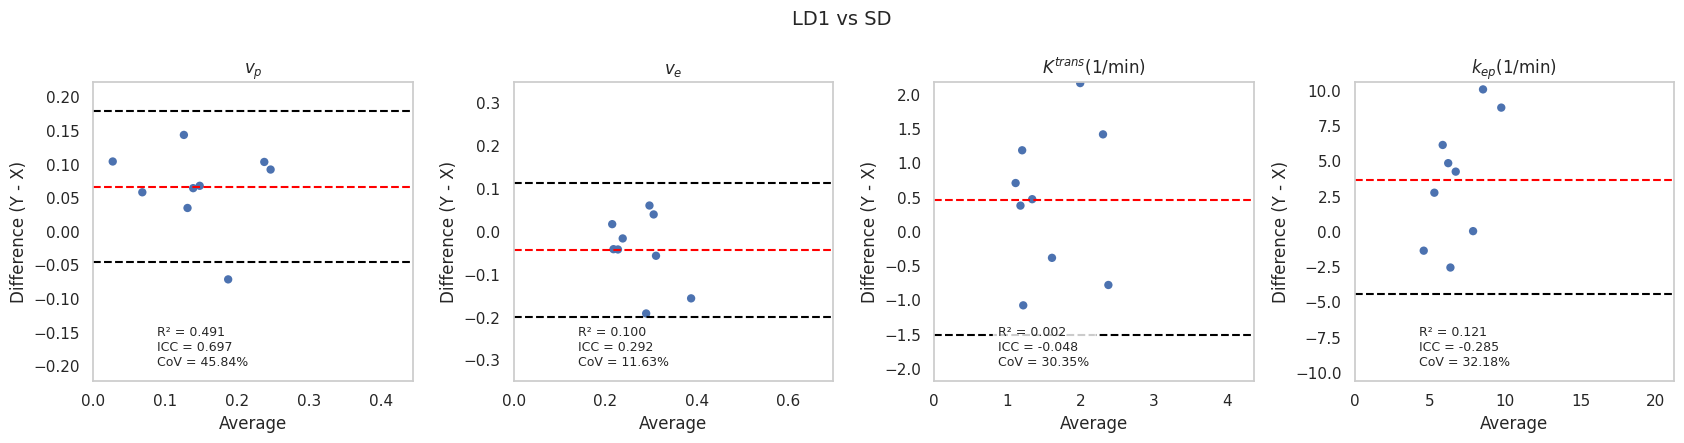

(8, 2)
(8, 2)
(8, 2)
(8, 2)


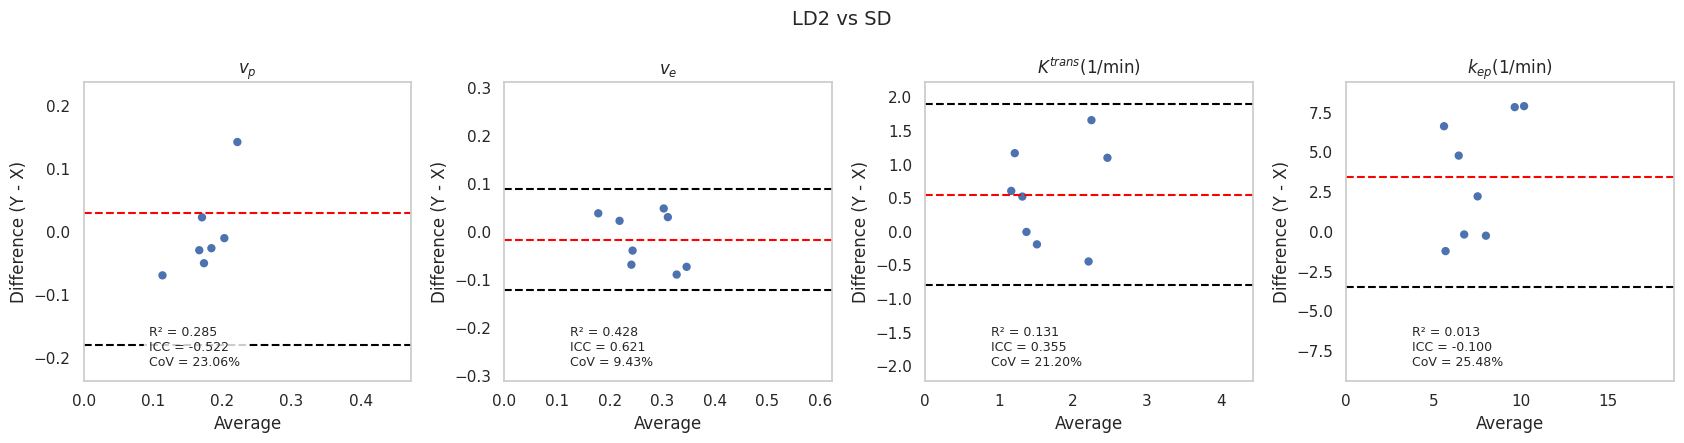

In [5]:
main('./output_mat/Output_extTofts_fitkep', './')
